In [140]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/grid-loss-time-series-dataset/test_backfilled_missing_data.csv
/kaggle/input/grid-loss-time-series-dataset/test.csv
/kaggle/input/grid-loss-time-series-dataset/train.csv


In [141]:
def shift_pandas_column(column, periods=24 * 7):
    return column.shift(periods, fill_value=column.mean())

def get_datasets(
    train_location="/kaggle/input/grid-loss-time-series-dataset/train.csv",
    test_location="/kaggle/input/grid-loss-time-series-dataset/test.csv",
):
    columns_to_drop = [
        "grid1-loss-prophet-daily",
        "grid1-loss-prophet-pred",
        "grid1-loss-prophet-trend",
        "grid1-loss-prophet-weekly",
        "grid1-loss-prophet-yearly",
        "grid2-load",
        "grid2-loss",
        "grid2-loss-prophet-daily",
        "grid2-loss-prophet-pred",
        "grid2-loss-prophet-trend",
        "grid2-loss-prophet-weekly",
        "grid2-loss-prophet-yearly",
        "grid2_1-temp",
        "grid2_2-temp",
        "grid3-load",
        "grid3-loss",
        "grid3-loss-prophet-daily",
        "grid3-loss-prophet-pred",
        "grid3-loss-prophet-trend",
        "grid3-loss-prophet-weekly",
        "grid3-loss-prophet-yearly",
        "grid3-temp",
    ]
    raw_train = pd.read_csv(train_location, parse_dates=True)
    raw_test = pd.read_csv(test_location, parse_dates=True)
    pruned_train = raw_train.drop(columns=columns_to_drop)
    pruned_test = raw_test.drop(columns=columns_to_drop)
    pruned_train = raw_train.drop(columns=columns_to_drop).fillna( method='ffill')
    pruned_test = raw_test.drop(columns=columns_to_drop).fillna( method='ffill')
    

    # get y values before shifting
    train_y = pruned_train["grid1-loss"].copy()
    test_y = pruned_test["grid1-loss"].copy()

    # shift grid loss and load features 1 week to emulate real world delay of measurements
    pruned_train["grid1-loss"] = shift_pandas_column(pruned_train["grid1-loss"])
    pruned_train["grid1-load"] = shift_pandas_column(pruned_train["grid1-load"])
    pruned_test["grid1-loss"] = shift_pandas_column(pruned_test["grid1-loss"])
    pruned_test["grid1-load"] = shift_pandas_column(pruned_test["grid1-load"])

    # give name to first column and change name on lagged load and loss
    pruned_train.rename(columns={"Unnamed: 0": "timestamp"}, inplace=True)
    pruned_test.rename(columns={"Unnamed: 0": "timestamp"}, inplace=True)
    pruned_train.rename(columns={"grid1-loss": "grid1-loss-lagged"}, inplace=True)
    pruned_test.rename(columns={"grid1-loss": "grid1-loss-lagged"}, inplace=True)
    pruned_train.rename(columns={"grid1-load": "grid1-load-lagged"}, inplace=True)
    pruned_test.rename(columns={"grid1-load": "grid1-load-lagged"}, inplace=True)
    
    
    train = (pruned_train, train_y)
    test = (pruned_test, test_y)

    #return pruned_train, pruned_test
    return train, test


In [142]:
(pruned_train, train_y), (pruned_test, test_y) = get_datasets()

In [143]:
import datetime as dt

datelist_train = list(pruned_train['timestamp'])
datelist_train = [dt.datetime.fromisoformat(date) for date in datelist_train]

datelist_test = list(pruned_test['timestamp'])
datelist_test = [dt.datetime.fromisoformat(date) for date in datelist_test]

In [144]:
#removes timestap beacuse bacause it can't be transformed to a float
float_train = pruned_train.drop(columns="timestamp")
dataset_train = float_train.values.astype(float)

float_test = pruned_test.drop(columns="timestamp")
dataset_test = float_test.values.astype(float)

In [145]:
from sklearn.preprocessing import StandardScaler

#makes and fits a scalar based on the X values in the training data
sc = StandardScaler()
training_set_scaled = sc.fit_transform(dataset_train)

#makes and fits a scalar based on the Y values in the training data
scTrainY = StandardScaler()
training_set_Y_scaled = scTrainY.fit_transform(train_y.values.astype(float).reshape(-1, 1))

#transformes the X and the Y values of the test data based on the fitted scaler form the training data
testing_set_Y_scaled = scTrainY.transform(test_y.values.astype(float).reshape(-1, 1))
testing_set_scaled = sc.transform(dataset_test)


In [146]:

X_train = []
y_train = []

#number of hours to predict into the future
n_future = 36
#number of days of each X value
n_past = 24

#makes a list of all X values, where 1 X values consists of the last "n_past" hours
#makes a list of all Y values, where 1 Y value consists of 1 "grid1-loss", and is "n_future" furthere ahead that the last values in the coresponding X value
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_Y_scaled[i + n_future - 1:i + n_future])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))


X_train shape == (17461, 24, 16).
y_train shape == (17461, 1, 1).


In [147]:

X_test = []
y_test = []

for i in range(n_past, len(testing_set_scaled) - n_future +1):
    X_test.append(testing_set_scaled[i - n_past:i, 0:dataset_test.shape[1]])
    y_test.append(training_set_Y_scaled[i + n_future - 1:i + n_future])

X_test, y_test = np.array(X_test), np.array(y_test)

print('X_train shape == {}.'.format(X_test.shape))
print('y_train shape == {}.'.format(y_test.shape))

X_train shape == (4310, 24, 16).
y_train shape == (4310, 1, 1).


In [148]:
X_combined = []
y_combined = []

#combines the test and traning data
#this is used for adding test data to traning data later
combined_X_scaled = np.concatenate((training_set_scaled, testing_set_scaled))
combined_Y_scaled = np.concatenate((training_set_Y_scaled, testing_set_Y_scaled))

for i in range(n_past, len(combined_X_scaled) - n_future +1):
    X_combined.append(combined_X_scaled[i - n_past:i, 0:dataset_test.shape[1] ])
    y_combined.append(combined_Y_scaled[i + n_future - 1:i + n_future])

X_combined, y_combined = np.array(X_combined), np.array(y_combined)

print('X_combined shape == {}.'.format(X_combined.shape))
print('y_combined shape == {}.'.format(y_combined.shape))

#removes exsisting traning data
X_combined = np.delete(X_combined, (range(17459)), axis=0)
y_combined = np.delete(y_combined, (range(17459)), axis=0)

print('X_combined shape == {}.'.format(X_combined.shape))
print('y_combined shape == {}.'.format(y_combined.shape))

X_combined shape == (21830, 24, 16).
y_combined shape == (21830, 1, 1).
X_combined shape == (4371, 24, 16).
y_combined shape == (4371, 1, 1).


In [149]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [150]:
model = Sequential()

#two LSTM layers
model.add(LSTM(units=32, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))
model.add(LSTM(units=8, return_sequences=False))
#added dropout to mitigtate overfitting
model.add(Dropout(0.25))
#1 output from dens layer
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')

#saves initial weigths, so that these can be loaded later, when resetting the traning 
model.save_weights('model.inital')

In [151]:
#trains the model with 20 % of training data used as validation data
history = model.fit(X_train, y_train, shuffle=True, epochs=3, verbose=1,validation_split=0.2, batch_size=96)

Epoch 1/3
146/146 [==============================] - 1s 10ms/step - loss: 0.3616 - val_loss: 0.1201
Epoch 2/3
146/146 [==============================] - 1s 6ms/step - loss: 0.1893 - val_loss: 0.0949
Epoch 3/3
146/146 [==============================] - 1s 6ms/step - loss: 0.1546 - val_loss: 0.0702


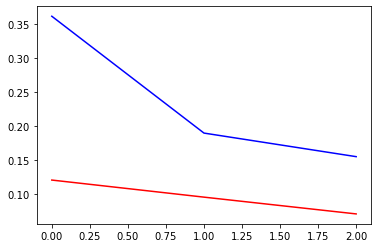

In [152]:
plt.plot(history.history['loss'][0:], label='train', color="blue")
plt.plot(history.history['val_loss'][0:], label='test', color="red")

In [153]:
#predicts n_future(36) next hours for each X value in the test and traning data
predictions_train = model.predict(X_train[n_past:])
predictions_test = model.predict(X_test[n_past:])

In [154]:
#invers transfomes the predicted train and test values back to normal values
y_pred_train = scTrainY.inverse_transform(predictions_train)
y_pred_test = scTrainY.inverse_transform(predictions_test)

In [155]:
from datetime import datetime
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d %H%M%S'), '%Y%m%d %H%M%S')

In [156]:
#makes a datafram from the predicted values with a timestamp as the index
prediction_train = pd.DataFrame(y_pred_train, columns=['grid-loss']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
prediction_test = pd.DataFrame(y_pred_test, columns=['grid-loss']).set_index(pd.Series(datelist_test[-24 + 2 * n_past + n_future -1:-24]))

prediction_train.index = prediction_train.index.to_series().apply(datetime_to_timestamp)
prediction_test.index = prediction_test.index.to_series().apply(datetime_to_timestamp)


actualLossTrain = pd.DataFrame(train_y.values).set_index(pd.Series(datelist_train))
actualLossTest = pd.DataFrame(test_y.values).set_index(pd.Series(datelist_test))

In [ ]:
allPredictions = []

numerOfIterations = 31

#trains "numerOfIterations" number of neural networks to simulate the training of a new neural nettwork every day with new traning data 
#recomended to use GPU to run this, takes approxomently 30 min with GPU, as it is traning 170 neural nettworks
for i in range(numerOfIterations): #økt til resten av testdata

    print(str(i+1) + "/" +  str(numerOfIterations))
    #resests the weights of the model to the initial weights
    model.load_weights('model.inital')
    
    #changes the verbose to 0(scilent) after 3 iterations
    if (i>2):
        history = model.fit(X_train, y_train, shuffle=True, epochs=10, verbose=0,validation_split=0.2, batch_size=96)
    else:
        history = model.fit(X_train, y_train, shuffle=True, epochs=10, verbose=2,validation_split=0.2, batch_size=96)
    
    #predicts the next 36 hours into the future based on the last 36 hours (n_future) starting on one week after the traning data
    #the windows moves 24 hours per day
    predictions_future = model.predict(X_test[24*7-n_future + 24*i:24*7 + 24*i])
    
    y_pred_future = scTrainY.inverse_transform(predictions_future)
    
    #sets the time index of the data, which is one week ahead of traning data 
    predictions_future_tmp = pd.DataFrame(y_pred_future, columns=['grid-loss']).set_index(pd.Series(datelist_test[7*24 + 24*i:7*24+n_future + 24*i]))
    
    #removes the first 12 hours that was predicted, as we are interested in 12 - 36 hours into the future
    predictions_future_tmp = predictions_future_tmp.drop(pd.Series(datelist_test[7*24 + 24*i:7*24+12 + 24*i]))
    allPredictions.append(predictions_future_tmp)
    
    #append 24 hours to training data
    X_train = np.concatenate((X_train, X_combined[24*i : 24*i + 24]))
    y_train = np.concatenate((y_train, y_combined[24*i : 24*i + 24]))
    
    

predictions_future = pd.concat(allPredictions)


1/31
Epoch 1/10
146/146 - 1s - loss: 0.3509 - val_loss: 0.1142
Epoch 2/10
146/146 - 1s - loss: 0.1869 - val_loss: 0.0892
Epoch 3/10
146/146 - 1s - loss: 0.1535 - val_loss: 0.0696
Epoch 4/10
146/146 - 1s - loss: 0.1371 - val_loss: 0.0643
Epoch 5/10
146/146 - 1s - loss: 0.1258 - val_loss: 0.0698
Epoch 6/10
146/146 - 1s - loss: 0.1191 - val_loss: 0.0731
Epoch 7/10
146/146 - 1s - loss: 0.1114 - val_loss: 0.0606
Epoch 8/10
146/146 - 1s - loss: 0.1059 - val_loss: 0.0714
Epoch 9/10
146/146 - 1s - loss: 0.0996 - val_loss: 0.0735
Epoch 10/10
146/146 - 1s - loss: 0.1000 - val_loss: 0.0691
2/31
Epoch 1/10
146/146 - 1s - loss: 0.3286 - val_loss: 0.1127
Epoch 2/10
146/146 - 1s - loss: 0.1825 - val_loss: 0.0817
Epoch 3/10
146/146 - 1s - loss: 0.1547 - val_loss: 0.0816
Epoch 4/10
146/146 - 1s - loss: 0.1359 - val_loss: 0.0659
Epoch 5/10
146/146 - 1s - loss: 0.1231 - val_loss: 0.0775
Epoch 6/10
146/146 - 1s - loss: 0.1189 - val_loss: 0.0996
Epoch 7/10
146/146 - 1s - loss: 0.1117 - val_loss: 0.0702
Epo

In [ ]:
def plotGraph(start_date, end_date, actualLossTimeFrame, actualLossTimeFrameTest, prediction_train, predictions_future, prediction_test):
    plt.plot(actualLossTrain.loc[start_date:end_date], label="ActualTrain")
    plt.plot(actualLossTest.loc[start_date:end_date], label="ActualTest")

    plt.plot(prediction_train.loc[start_date:end_date], label="trainPredict")
    plt.plot(predictions_future.loc[start_date:end_date], label="futurePredict")
    #plt.plot(prediction_test.loc[start_date:end_date], label="testPredict")

In [ ]:
plotGraph('2019-11-20', '2019-12-20', actualLossTimeFrame, actualLossTimeFrameTest, prediction_train, predictions_future, prediction_test)

In [ ]:
plotGraph('2019-12-06', '2019-12-13', actualLossTimeFrame, actualLossTimeFrameTest, prediction_train, predictions_future, prediction_test)

In [ ]:
plotGraph('2017-01-27', '2020-06-03', actualLossTimeFrame, actualLossTimeFrameTest, prediction_train, predictions_future, prediction_test)

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, median_absolute_error as medae

def runEvaluation(y_true, y_pred):
    
    metrics = [mae, root_mean_squared_error, mean_absolute_percentage_error]
    return [calc(y_true, y_pred) for calc in metrics]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


In [ ]:
start_date_train = '2018-02-01'
evaluation = runEvaluation(prediction_train.loc[start_date_train:], actualLossTrain.loc[start_date_train:])
print(evaluation)


start_date_test = '2020-01-01'
end_date_test = '2020-05-01'
evaluationTest = runEvaluation(prediction_test.loc[start_date_test:end_date_test], actualLossTest.loc[start_date_test:end_date_test])
print(evaluationTest)


start_date_predict = str(predictions_future[0:1].index)[16:35]
end_date_predict = str(predictions_future[-1:].index)[16:35]
evaluationPrediction = runEvaluation(predictions_future.loc[start_date_predict:end_date_predict], actualLossTest.loc[start_date_predict:end_date_predict])
print(evaluationPrediction)